In [120]:
%load_ext autoreload
%autoreload 2
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

def gen_x_next(x_k, u_k, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k+dt/2*k1, u_k)
    k3 = f(x_k+dt/2*k2, u_k)
    k4 = f(x_k+dt*k3,   u_k)
    x_next = x_k + dt/6*(k1+2*k2+2*k3+k4) 
    return x_next
# F = cas.Function('F',[x,u,t],[ode],)

#  States

$\vec{x}$ = $[x, y, \phi, \delta, V, s]^T$

$\vec{u}$ = $[\delta^u, v^u]^T$

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [121]:
T = 10 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals

intg_options = {}
intg_options['tf'] = dt # from dt
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 6  #from 4

dae = {}  #What's a DAE?
dae['x'] = x
dae['p'] = u
dae['ode'] = f(x,u)
intg = cas.integrator('intg','rk', dae, intg_options)
res = intg(x0=x,p=u)
x_next = res['xf']
F = cas.Function('F',[x,u],[x_next],['x','u'],['x_next'])

# Problem Definition
### Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [122]:
s = cas.MX.sym('s')
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)
fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

In [123]:
#Globally true information
min_dist = 2 * (2 * .5**2)**.5

# initial_speed = 6.7 
initial_speed = 20 * 0.447 # m/s

# Initial Conditions
x0 = np.array([2*min_dist, 1.2*min_dist, 0, 0, initial_speed, 0]).T
x0_2 = np.array([2*min_dist, 0, .0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.1 * initial_speed , 0]).T

In [124]:
LANE_WIDTH = min_dist
xd2 = s
yd2 = LANE_WIDTH
phid = 0
des_traj2 = cas.vertcat(xd2, yd2, phid)
fd2 = cas.Function('fd',[s],[des_traj2],['s'],['des_traj2'])

## IBR from Beginning

### Solve it centrally just to warm start the solution

In [125]:
x1_MPC = mpc.MPC(dt)
x2_MPC = mpc.MPC(dt)
amb_MPC = mpc.MPC(dt)

x1_MPC.theta_iamb = np.pi/4.0
x2_MPC.theta_iamb = np.pi/4.0
amb_MPC.theta_iamb = np.pi/4.0


x1_MPC.k_s = -1.0
x2_MPC.k_s = -1.0

amb_MPC.theta_iamb = 0.0
amb_MPC.k_u_v = 0.10
# amb_MPC.k_u_change = 1.0
amb_MPC.k_s = -1.0
amb_MPC.max_v = 40 * 0.447 # m/s
amb_MPC.max_X_dev = 5.0


x2_MPC.fd = fd
amb_MPC.fd = fd
x1_MPC.fd = fd2


x1_MPC.min_y = -1.1 * LANE_WIDTH
x2_MPC.min_y = -1.1 * LANE_WIDTH
amb_MPC.min_y = -1.1 * LANE_WIDTH

## Initialize values from the centralized version
x1_current, u1_current, x1_desired_current = x1, u1, x1_des
x2_current, u2_current, x2_desired_current = x2, u2, x2_des
xamb_current, uamb_current, xamb_desired_current = xamb, uamb, xamb_des

In [126]:
u2 = np.zeros((2,N))
u1 = np.zeros((2,N))

In [127]:
br1 = mpc.IterativeBestResponseMPC(amb_MPC, x1_MPC, x2_MPC)
br1.generate_optimization(N, min_dist, fd, T, x0_amb, x0, x0_2,  2)
br1.solve(u1, u2)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  15.82ms (239.67us)  15.83ms (239.92us)        66
       nlp_g  | 107.96ms (  1.64ms) 107.72ms (  1.63ms)        66
    nlp_grad  |   6.81ms (  6.81ms)   6.79ms (  6.79ms)         1
  nlp_grad_f  |  20.27ms (547.89us)  20.30ms (548.67us)        37
  nlp_hess_l  | 900.28ms ( 15.26ms) 896.94ms ( 15.20ms)        59
   nlp_jac_g  | 671.05ms ( 10.65ms) 668.74ms ( 10.61ms)        63
       total  |   2.43 s (  2.43 s)   2.42 s (  2.42 s)         1


In [128]:
xamb, uamb, xamb_des, x1, u1, x1_des, x2, u2, x2_des = br1.get_solution()

In [129]:
optional_suffix = "_ibr_amb_first"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)

results/20200219-133152_ibr_amb_first/


In [131]:
br1.save_state(folder + "1", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)

'results/20200219-133152_ibr_amb_first/1'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

SystemError: <built-in method write of _io.BufferedWriter object at 0x7efdfc45f110> returned a result with an error set

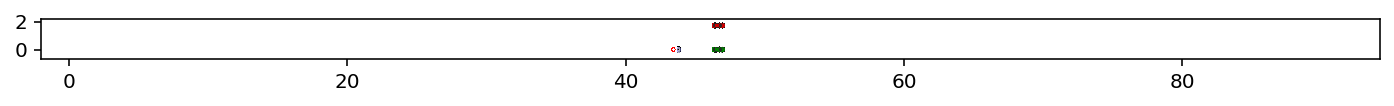

In [133]:
CIRCLES = False
cplot.plot_cars(x1, x2, xamb, folder, None, None, None, CIRCLES, min_dist)
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle1.mp4'
else:
    vid_fname = folder + subdir_name + 'car1.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [143]:
br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
br2.solve(u1, uamb)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  45.29ms (462.12us)  45.33ms (462.57us)        98
       nlp_g  | 165.51ms (  1.69ms) 165.23ms (  1.69ms)        98
    nlp_grad  |   7.84ms (  7.84ms)   7.80ms (  7.80ms)         1
  nlp_grad_f  |  70.11ms (844.72us)  70.02ms (843.63us)        83
  nlp_hess_l  |   1.65 s ( 17.73ms)   1.64 s ( 17.67ms)        93
   nlp_jac_g  | 951.70ms (  9.81ms) 948.43ms (  9.78ms)        97
       total  |   3.91 s (  3.91 s)   3.89 s (  3.89 s)         1


In [144]:
x2, u2, x2_des, x1, u1, x1_des, xamb, uamb, xamb_des = br2.get_solution()

In [145]:
br2.solution.value(br2.slack_cost)

2.2076204947209428e-07

In [147]:
br2.save_state(folder + "2_2", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)

'results/20200219-133152_ibr_amb_first/2_2'

In [148]:
br3 = mpc.IterativeBestResponseMPC(amb_MPC, x2_MPC, x1_MPC)
br3.generate_optimization(N, min_dist, fd, T, x0_amb, x0_2, x0, 2, slack=True)
br3.solve(u2, u1)
xamb, uamb, xamb_des, x2, u2, x2_des, x1, u1, x1_des = br3.get_solution()
br3.solution.value(br3.slack_cost)
br3.save_state(folder + "3_a", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   8.20ms ( 82.04us)   8.18ms ( 81.85us)       100
       nlp_g  | 117.49ms (  1.17ms) 117.13ms (  1.17ms)       100
    nlp_grad  |   4.27ms (  4.27ms)   4.27ms (  4.27ms)         1
  nlp_grad_f  |  19.29ms (244.14us)  19.29ms (244.22us)        79
  nlp_hess_l  |   1.33 s ( 14.31ms)   1.33 s ( 14.27ms)        93
   nlp_jac_g  | 832.43ms (  8.58ms) 829.86ms (  8.56ms)        97
       total  |   3.40 s (  3.40 s)   3.39 s (  3.39 s)         1


In [152]:
CIRCLES = False
cplot.plot_cars(x1, x2, xamb, folder, None, None, None, CIRCLES, min_dist)
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle3.mp4'
else:
    vid_fname = folder + subdir_name + 'car3.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving video to: results/20200219-133152_ibr_amb_first/20200219-133152_ibr_amb_firstcar3.mp4


In [ ]:
br4 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
br4.generate_optimization(N, min_dist, fd, T, x0_amb, x0_2, x0, 2, slack=True)
br4.solve(u2, u1)
xamb, uamb, xamb_des, x2, u2, x2_des, x1, u1, x1_des = br4.get_solution()
br4.solution.value(br4.slack_cost)
br4.save_state(folder + "3_a", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)

## Decentralized:  IBR to Converge

In [ ]:
## Initialize values from the centralized version
x1_current, u1_current, x1_desired_current = x1, u1, x1_des
x2_current, u2_current, x2_desired_current = x2, u2, x2_des
xamb_current, uamb_current, xamb_desired_current = xamb, uamb, xamb_des

In [ ]:
br1 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
br1.generate_optimization(N, min_dist, fd, T, x0, x0_2, x0_amb, 2)

x1r1, u1r1, x1_desr1 = br1.get_solution(x2_current, u2_current, x2_desired_current, xamb_current, uamb_current, xamb_desired_current)
x1_current, u1_current, x1_desired_current = x1r1, u1r1, x1_desr1

cplot.plot_cars(x1_current, x2_current, xamb_current, folder)
CIRCLES = False
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle1.mp4'
else:
    vid_fname = folder + subdir_name + 'car1.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC)
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2)
br2.opti.set_initial(br2.x_opt, x2_current) # initialize it with the previous solution
x2r2, u2r2, x2_desr2 = br2.get_solution(x1_current, u1_current, x1_desired_current, xamb_current, uamb_current, xamb_desired_current)
x2_current, u2_current, x2_desired_current = x2r2, u2r2, x2_desr2

In [ ]:
cplot.plot_cars(x1_current, x2_current, xamb_current, folder)

In [ ]:
CIRCLES = False
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle2.mp4'
else:
    vid_fname = folder + subdir_name + 'car2.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_v_cost = car1_s_cost
car2_v_cost = car2_s_cost
amb_v_cost = amb_s_cost

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     